# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

### Задача

Провести классификацию фотографий кошек и собак

In [74]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
from keras.applications import vgg16, resnet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import regularizers
from keras import optimizers

import os
from random import shuffle
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from IPython.display import Image

print(tf.__version__)
print(tf.executing_eagerly())

2.7.0
True


In [18]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('data/dogs-vs-cats-redux-kernels-edition/test/*.jpg')

#### Функции загрузки и визуализации данных

In [96]:

# загрузка и предобработка входного изображения
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])
            
# Визуализация примеров для обучения
def show_images_example():
    fig = plt.figure(figsize=(16, 8))
    for i, path in enumerate(train_files[:10], 1):
        subplot = fig.add_subplot(2, 5, i)
        subplot.set_title('%s' % path.split('/')[-1])
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        plt.imshow(img)
        
# визуализация предсказания на тестовых данных
def show_test_images_with_predictions(test_files, test_pred):
    fig = plt.figure(figsize=(16, 8))
    labels = ['dog' if i > 0.5 else 'cat' for i in test_pred]
    for i, (path, label) in enumerate(zip(test_files[:10], labels[:10]), 1):
        subplot = fig.add_subplot(2, 5, i)
        subplot.set_title('%s %s' % (label, os.path.basename(path)))
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)

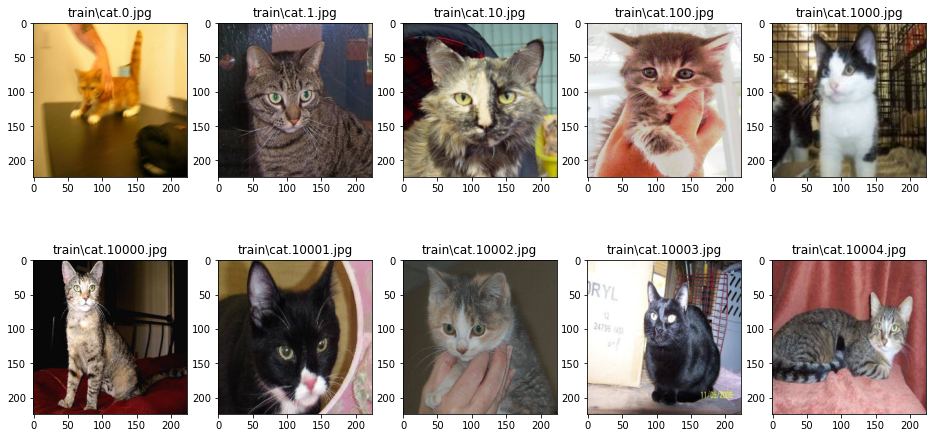

In [20]:
show_images_example()

In [66]:
train = []                                   
label = []                                    

for i in os.listdir('data/dogs-vs-cats-redux-kernels-edition/train'):                             
    train_class = i.split(".", 1)
    for j in train_class[0:1]:
        train.append(i)                         
        label.append(j)                         
        
full_df = pd.DataFrame({'Image': train,'Labels': label})  
full_df.head()

Image Labels
0     cat.0.jpg    cat
1     cat.1.jpg    cat
2    cat.10.jpg    cat
3   cat.100.jpg    cat
4  cat.1000.jpg    cat

<AxesSubplot:xlabel='Labels', ylabel='count'>

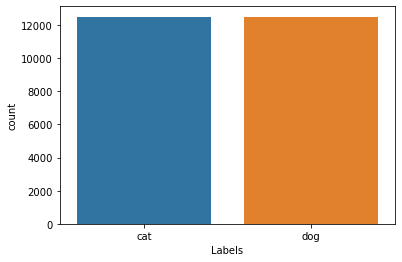

In [67]:
sns.countplot(full_df.Labels)

Распределение классов равномерное

### Модель на основе VGG16

In [11]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Добавляем полносвязный слой для решения задачи бинарной классификации

In [15]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [16]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

#### Компилируем модель и запускаем обучение

In [17]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [32]:
print(len(train_files))

25000


In [35]:
val_samples = 5000  # число изображений для валидационной выборки

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором


In [68]:
# коллбэки для подстраховки от переобучения
my_callback_rlr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

my_callback_es = EarlyStopping(patience=5)

In [71]:
history = model.fit(train_data,
          steps_per_epoch=10, 
          epochs=100,  
          validation_data=validation_data,
          callbacks=[my_callback_es, my_callback_rlr])

Epoch 1/100
10/10 [==============================] - 1326s 146s/step - loss: 0.5457 - accuracy: 0.9688 - val_loss: 0.4819 - val_accuracy: 0.9718 - lr: 2.5000e-04
Epoch 2/100
10/10 [==============================] - 1289s 142s/step - loss: 0.4228 - accuracy: 0.9750 - val_loss: 0.4915 - val_accuracy: 0.9728 - lr: 2.5000e-04
Epoch 3/100
10/10 [==============================] - 1275s 141s/step - loss: 0.4831 - accuracy: 0.9750 - val_loss: 0.4568 - val_accuracy: 0.9734 - lr: 2.5000e-04
Epoch 4/100
10/10 [==============================] - 1270s 140s/step - loss: 0.4335 - accuracy: 0.9688 - val_loss: 0.4862 - val_accuracy: 0.9720 - lr: 2.5000e-04
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.9656
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
10/10 [==============================] - 1272s 140s/step - loss: 0.6130 - accuracy: 0.9656 - val_loss: 0.5960 - val_accuracy: 0.9682 - lr: 2.5000e-04
Epoch 6/100
10/10 [========

#### Проверка на тестовых данных

In [72]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

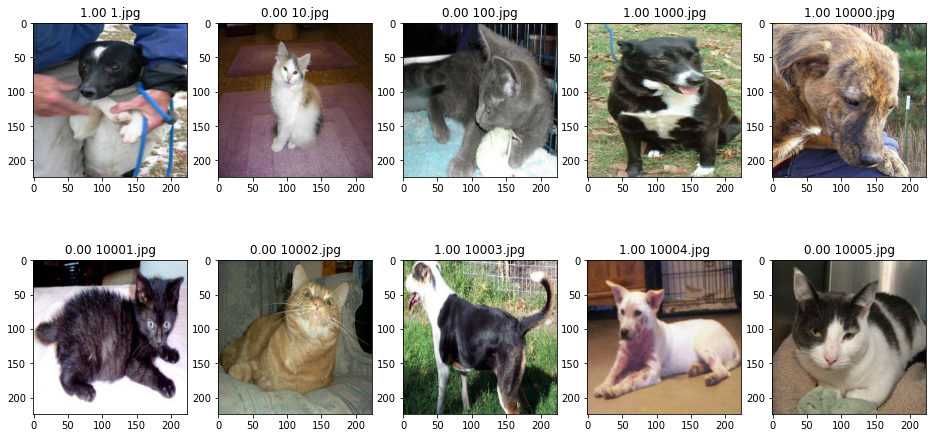

In [76]:
show_test_images_with_predictions(test_files, test_pred)

In [77]:
with open('vgg16_score.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

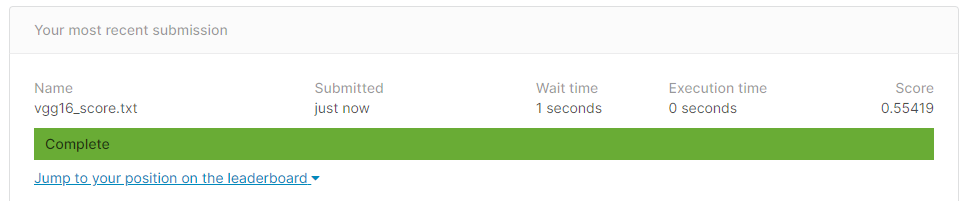

In [78]:
Image('images/vgg16_score.jpg')

### Модель на основе ResNet-50

In [85]:
model_resnet = resnet.ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [86]:
# фиксируем все веса предобученной сети
for layer in model_resnet.layers:
    layer.trainable = False

x = model_resnet.layers[-1].output
x = tf.keras.layers.Dense(1, activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model_resnet = tf.keras.Model(inputs=model_resnet.input, outputs=x, name='dogs_vs_cats_resnet')

In [87]:
model_resnet.summary()

Model: "dogs_vs_cats_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                

In [88]:
model_resnet.compile(optimizer='adam', 
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [89]:
# обучение 
history = model_resnet.fit(train_data,
          steps_per_epoch=10, 
          epochs=100,  
          validation_data=validation_data,
          callbacks=[my_callback_es, my_callback_rlr])

Epoch 1/100
10/10 [==============================] - 513s 56s/step - loss: 0.6950 - accuracy: 0.5406 - val_loss: 0.6942 - val_accuracy: 0.5554 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 519s 57s/step - loss: 0.6925 - accuracy: 0.5781 - val_loss: 0.6908 - val_accuracy: 0.6586 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 502s 55s/step - loss: 0.6892 - accuracy: 0.6938 - val_loss: 0.6875 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 482s 53s/step - loss: 0.6853 - accuracy: 0.7844 - val_loss: 0.6844 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 494s 55s/step - loss: 0.6822 - accuracy: 0.8250 - val_loss: 0.6814 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 489s 54s/step - loss: 0.6806 - accuracy: 0.8313 - val_loss: 0.6784 - val_accuracy: 0.8374 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 487s 54s/st

Epoch 47/100
10/10 [==============================] - 477s 53s/step - loss: 0.6318 - accuracy: 0.9563 - val_loss: 0.6314 - val_accuracy: 0.9650 - lr: 1.5625e-05
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.9469
Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-05.
10/10 [==============================] - 470s 52s/step - loss: 0.6304 - accuracy: 0.9469 - val_loss: 0.6314 - val_accuracy: 0.9650 - lr: 1.5625e-05
Epoch 49/100
10/10 [==============================] - 471s 52s/step - loss: 0.6310 - accuracy: 0.9656 - val_loss: 0.6314 - val_accuracy: 0.9650 - lr: 1.0000e-05
Epoch 50/100
10/10 [==============================] - 470s 52s/step - loss: 0.6307 - accuracy: 0.9688 - val_loss: 0.6313 - val_accuracy: 0.9650 - lr: 1.0000e-05
Epoch 51/100
10/10 [==============================] - 470s 52s/step - loss: 0.6295 - accuracy: 0.9812 - val_loss: 0.6313 - val_accuracy: 0.9650 - lr: 1.0000e-05
Epoch 52/100
10/10 [============================

Epoch 97/100
10/10 [==============================] - 469s 52s/step - loss: 0.6318 - accuracy: 0.9719 - val_loss: 0.6303 - val_accuracy: 0.9650 - lr: 1.0000e-05
Epoch 98/100
10/10 [==============================] - 468s 52s/step - loss: 0.6268 - accuracy: 0.9812 - val_loss: 0.6302 - val_accuracy: 0.9650 - lr: 1.0000e-05
Epoch 99/100
10/10 [==============================] - 468s 52s/step - loss: 0.6319 - accuracy: 0.9438 - val_loss: 0.6302 - val_accuracy: 0.9650 - lr: 1.0000e-05
Epoch 100/100
10/10 [==============================] - 468s 52s/step - loss: 0.6289 - accuracy: 0.9750 - val_loss: 0.6302 - val_accuracy: 0.9650 - lr: 1.0000e-05


#### Проверка на тестовых данных

In [90]:
test_pred = model_resnet.predict(
    predict_generator(test_files), steps=len(test_files))

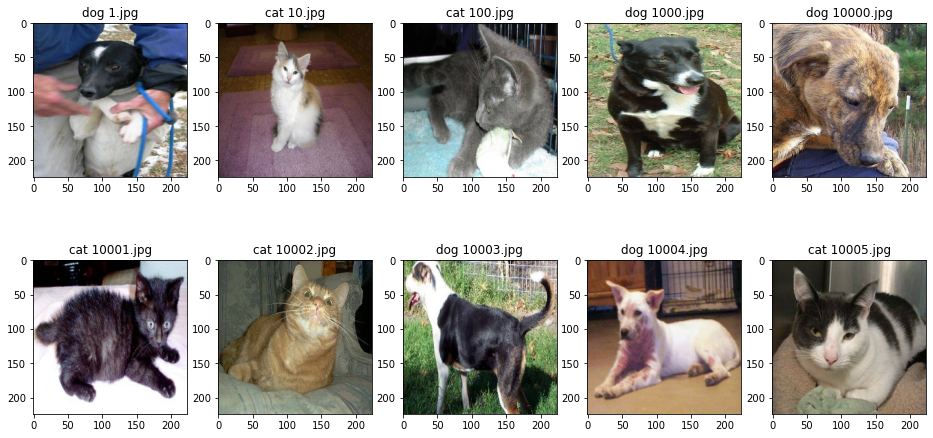

In [97]:
show_test_images_with_predictions(test_files, test_pred)

In [92]:
with open('resnet_score.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

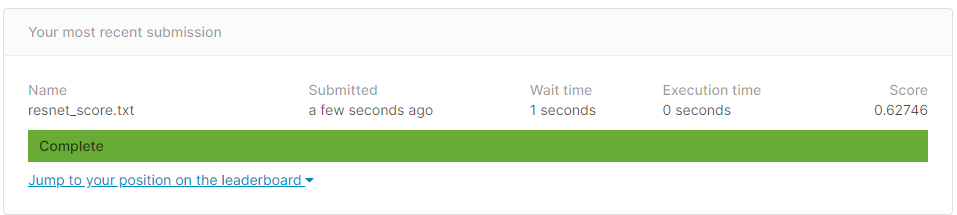

In [93]:
Image('images/resnet_score.jpg')

### Простая сверточная модель

Пробую чуть более простую модель, с меньшим количеством сверточных слоев

In [23]:
model_new = tf.keras.models.Sequential([
    
    #Conv layer 1
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.0001), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

opt = optimizers.Adam(learning_rate=0.0001)
model_new.compile(loss="binary_crossentropy",
              optimizer=opt, metrics=["accuracy"])

In [24]:
model_new.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 128)     204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 49, 49, 128)       409728    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 128)      

#### Обучение

In [32]:
model_new.fit(
    train_data,
    epochs=20,
    steps_per_epoch=500,
    verbose=1,
    validation_data=validation_data
    callbacks = [my_callback_es, my_callback_rlr]
)

Epoch 1/20
500/500 [==============================] - 4363s 9s/step - loss: 0.6798 - accuracy: 0.6263 - val_loss: 0.6087 - val_accuracy: 0.6968
Epoch 2/20
500/500 [==============================] - 4871s 10s/step - loss: 0.5998 - accuracy: 0.7033 - val_loss: 0.5454 - val_accuracy: 0.7456
Epoch 3/20
500/500 [==============================] - 4457s 9s/step - loss: 0.5185 - accuracy: 0.7653 - val_loss: 0.5159 - val_accuracy: 0.7670
Epoch 4/20
500/500 [==============================] - 3971s 8s/step - loss: 0.4630 - accuracy: 0.8012 - val_loss: 0.4641 - val_accuracy: 0.7950
Epoch 5/20
500/500 [==============================] - 3971s 8s/step - loss: 0.4114 - accuracy: 0.8323 - val_loss: 0.4305 - val_accuracy: 0.8314
Epoch 6/20
500/500 [==============================] - 3972s 8s/step - loss: 0.3571 - accuracy: 0.8622 - val_loss: 0.3773 - val_accuracy: 0.8484
Epoch 7/20
500/500 [==============================] - 3970s 8s/step - loss: 0.2891 - accuracy: 0.8927 - val_loss: 0.3792 - val_accuracy

#### Проверка на тестовых данных

In [38]:
test_pred = model_new.predict(
    predict_generator(test_files), steps=len(test_files))

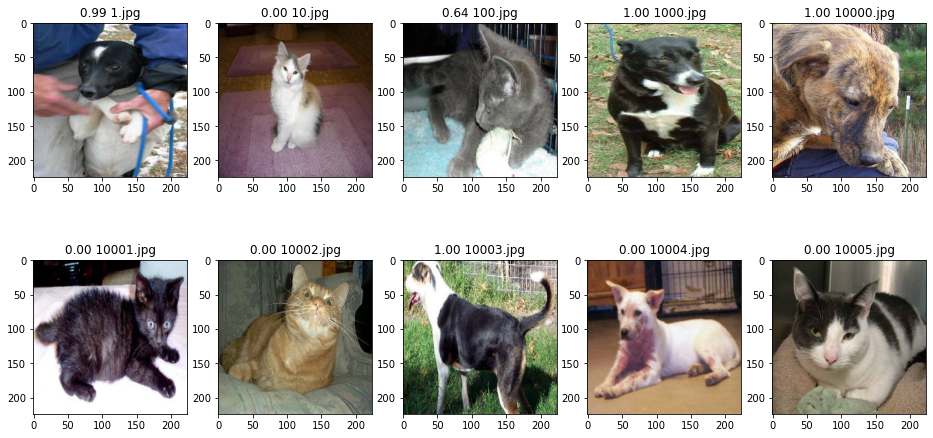

In [39]:
show_test_images_with_predictions(test_files, test_pred)

In [40]:
with open('submit_model_new.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

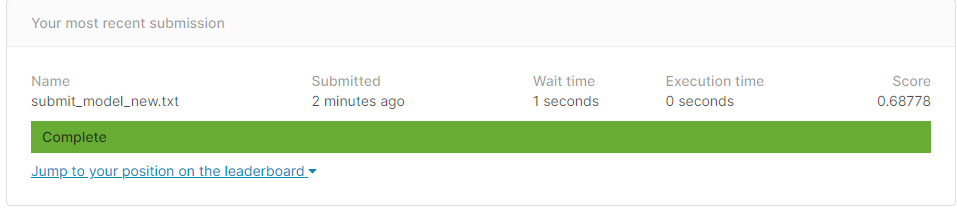

In [34]:
Image('images/new_model_score.jpg')

Попробую расширить и улучшить эту архитектуру 

In [13]:
model = tf.keras.models.Sequential([
    #Conv layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 5
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001))
    
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 128)      

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit_generator(
    train_data, 
    steps_per_epoch = 100,
    epochs = 100,
    verbose = 1,
    validation_data = validation_data,
    callbacks=[my_callback_es, my_callback_rlr]
)

Epoch 1/100
100/100 [==============================] - 380s 4s/step - loss: 2.4390 - acc: 0.5781 - val_loss: 2.5332 - val_acc: 0.5412
Epoch 2/100
100/100 [==============================] - 380s 4s/step - loss: 1.4545 - acc: 0.6047 - val_loss: 1.4997 - val_acc: 0.6464
Epoch 3/100
100/100 [==============================] - 378s 4s/step - loss: 1.0187 - acc: 0.6447 - val_loss: 0.9554 - val_acc: 0.6710
Epoch 4/100
100/100 [==============================] - 379s 4s/step - loss: 0.8338 - acc: 0.6869 - val_loss: 1.0673 - val_acc: 0.6444
Epoch 5/100
100/100 [==============================] - 381s 4s/step - loss: 0.7651 - acc: 0.7016 - val_loss: 0.7182 - val_acc: 0.7136
Epoch 6/100
100/100 [==============================] - 379s 4s/step - loss: 0.6959 - acc: 0.7312 - val_loss: 0.6934 - val_acc: 0.7276
Epoch 7/100
100/100 [==============================] - 376s 4s/step - loss: 0.6668 - acc: 0.7359 - val_loss: 0.6517 - val_acc: 0.7598
Epoch 8/100
100/100 [==============================] - 376s 4s

In [22]:
model.save('model3-cats-dogs-vgg16.hdf5')

Здесь коллбэки прервали обучение относительно рано, целевой показатель val_accuraсy несколько последних эпох изменяется незначительно, даже с учетом уменьшения learning rate за счет другого коллбэка. Проверим, достаточно ли нам такого качества в результате

In [24]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

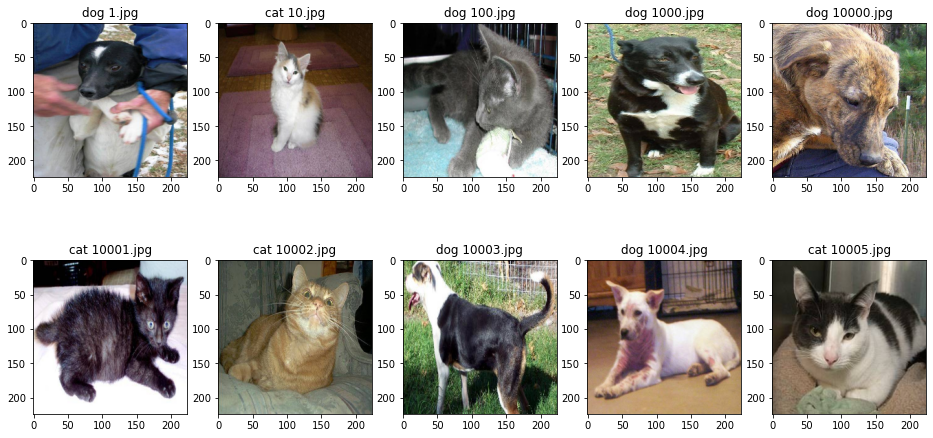

In [100]:
show_test_images_with_predictions(test_files, test_pred)

In [28]:
with open('submit-3.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

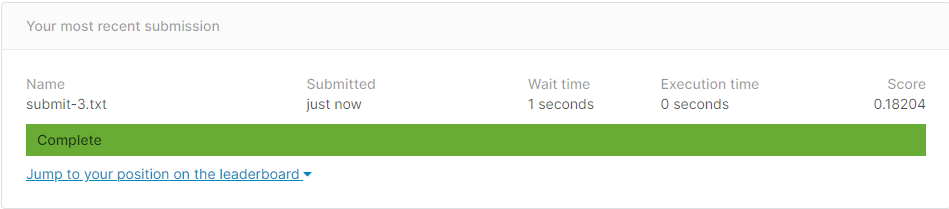

In [30]:
Image('images/model_3_score.jpg')

Это наилучший результат из имеющихся